In [1]:
import mpramnist
from mpramnist.Sharpr.dataset import SharprDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
from mpramnist.trainers import LitModel_Sharpr

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import lightning.pytorch as L
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics import PearsonCorrCoef

from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt

# Initiate some parameters

In [2]:
BATCH_SIZE = 96
NUM_WORKERS = 103

In [3]:
SharprDataset.ACTIVITY_COLUMNS

['k562_minp_rep1',
 'k562_minp_rep2',
 'k562_minp_avg',
 'k562_sv40p_rep1',
 'k562_sv40p_rep2',
 'k562_sv40p_avg',
 'hepg2_minp_rep1',
 'hepg2_minp_rep2',
 'hepg2_minp_avg',
 'hepg2_sv40p_rep1',
 'hepg2_sv40p_rep2',
 'hepg2_sv40p_avg']

In [4]:
def meaned_prediction(forw, rev, trainer, seq_model, name):

    predictions_forw = trainer.predict(seq_model, dataloaders = forw)
    targets = torch.cat([pred["target"] for pred in predictions_forw])
    y_preds_forw = torch.cat([pred["predicted"] for pred in predictions_forw])
    
    predictions_rev = trainer.predict(seq_model, dataloaders = rev)
    y_preds_rev = torch.cat([pred["predicted"] for pred in predictions_rev])
    
    mean_forw = torch.mean(torch.stack([y_preds_forw, y_preds_rev]), dim=0)
    
    pears = PearsonCorrCoef(num_outputs = 12)
    print(name + " Pearson correlation")
    
    return pears(mean_forw, targets)

In [5]:
# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5),
])
test_transform = t.Compose([
    t.Seq2Tensor(), 
])

# Train

In [6]:
# load the data
train_dataset = SharprDataset(split="train", transform=train_transform, root = "../data/")# for needed folds

val_dataset = SharprDataset( split="val", transform=test_transform, root = "../data/") # use "val" for default validation set

test_dataset = SharprDataset( split="test", transform=test_transform, root = "../data/") # use "test" for default test set

In [7]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset SharprDataset of size 457174 (MpraDaraset)
    Number of datapoints: 457174
    Used split fold: train
Dataset SharprDataset of size 10130 (MpraDaraset)
    Number of datapoints: 10130
    Used split fold: val
Dataset SharprDataset of size 10130 (MpraDaraset)
    Number of datapoints: 10130
    Used split fold: test


In [8]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [9]:
in_channels = len(train_dataset[0][0])
out_channels = len(SharprDataset.ACTIVITY_COLUMNS)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.06E-04


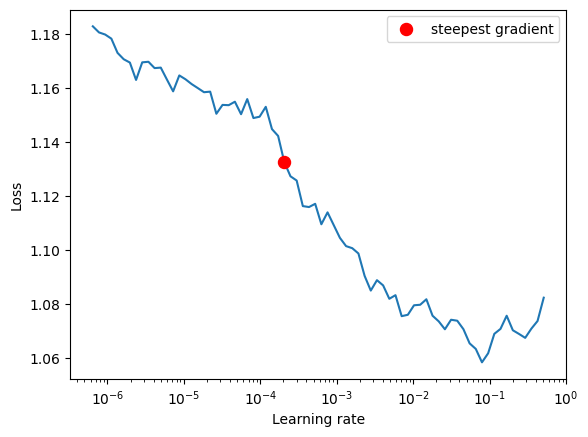

In [10]:
# search good lr
model = HumanLegNet(in_ch=in_channels,
                     output_dim = out_channels,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[256, 128, 128, 128, 64, 64],
                     pool_sizes=[2,2,2,2,2,2],
                     resize_factor=4)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 1e-4)
criterion = nn.MSELoss() 

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)

lr_finder.plot()  
plt.show()

Since we're using OneCycleLR in HumanLegNet, we should take the extreme points of the descent: lr = 1.5e-4

In [11]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = out_channels,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Sharpr(model = model,
                           loss = nn.MSELoss(), 
                           activity_columns = SharprDataset.ACTIVITY_COLUMNS,
                           weight_decay = 1e-4, lr = 1.5e-4, print_each = 10)

In [12]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_loss', 
        mode='min',  
        save_top_k=1,
        save_last=False
    )
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback]
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | model         | HumanLegNet     | 1.3 M  | train
1 | loss          | MSELoss         | 0      | train
2 | train_pearson | PearsonCorrCoef | 0      | train
3 | val_pearson   | PearsonCorrCoef | 0      | train
4 | test_pearson  | PearsonCorrCoef | 0      | train
----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.301  

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Loss: 0.99241 | Val Pearson: k562_minp_rep1 : 0.1836821585893631, k562_minp_rep2 : 0.26390448212623596, k562_minp_avg : 0.2618497312068939, k562_sv40p_rep1 : 0.08037997037172318, k562_sv40p_rep2 : 0.08042032271623611, k562_sv40p_avg : 0.08222232013940811, hepg2_minp_rep1 : 0.15127506852149963, hepg2_minp_rep2 : 0.11433204263448715, hepg2_minp_avg : 0.14435410499572754, hepg2_sv40p_rep1 : 0.1296854317188263, hepg2_sv40p_rep2 : 0.11210045218467712, hepg2_sv40p_avg : 0.1378677785396576, | Train Pearson: 0.35123 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 19 | Val Loss: 1.01064 | Val Pearson: k562_minp_rep1 : 0.18618889153003693, k562_minp_rep2 : 0.2510790228843689, k562_minp_avg : 0.2536179721355438, k562_sv40p_rep1 : 0.06848883628845215, k562_sv40p_rep2 : 0.06848490238189697, k562_sv40p_avg : 0.07533908635377884, hepg2_minp_rep1 : 0.1645689606666565, hepg2_minp_rep2 : 0.14230749011039734, hepg2_minp_avg : 0.1674228310585022, hepg2_sv40p_rep1 : 0.148456409573555, hepg2_sv40p_rep2 : 0.1389690488576889, hepg2_sv40p_avg : 0.16535122692584991, | Train Pearson: 0.43779 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 29 | Val Loss: 1.06930 | Val Pearson: k562_minp_rep1 : 0.1628054827451706, k562_minp_rep2 : 0.23938727378845215, k562_minp_avg : 0.2332845777273178, k562_sv40p_rep1 : 0.04839147999882698, k562_sv40p_rep2 : 0.04841233417391777, k562_sv40p_avg : 0.06801199913024902, hepg2_minp_rep1 : 0.1331956535577774, hepg2_minp_rep2 : 0.10052168369293213, hepg2_minp_avg : 0.1251719444990158, hepg2_sv40p_rep1 : 0.12318266928195953, hepg2_sv40p_rep2 : 0.11988329142332077, hepg2_sv40p_avg : 0.13962577283382416, | Train Pearson: 0.53356 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 39 | Val Loss: 1.15404 | Val Pearson: k562_minp_rep1 : 0.13909286260604858, k562_minp_rep2 : 0.208574116230011, k562_minp_avg : 0.20172119140625, k562_sv40p_rep1 : 0.03467486426234245, k562_sv40p_rep2 : 0.03467761352658272, k562_sv40p_avg : 0.04959936439990997, hepg2_minp_rep1 : 0.11726048588752747, hepg2_minp_rep2 : 0.09171992540359497, hepg2_minp_avg : 0.11186090856790543, hepg2_sv40p_rep1 : 0.11631269007921219, hepg2_sv40p_rep2 : 0.1170414462685585, hepg2_sv40p_avg : 0.13386383652687073, | Train Pearson: 0.61229 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Loss: 1.18125 | Val Pearson: k562_minp_rep1 : 0.13005144894123077, k562_minp_rep2 : 0.19844941794872284, k562_minp_avg : 0.1901623159646988, k562_sv40p_rep1 : 0.025770658627152443, k562_sv40p_rep2 : 0.02577263116836548, k562_sv40p_avg : 0.04278036206960678, hepg2_minp_rep1 : 0.10858959704637527, hepg2_minp_rep2 : 0.08260546624660492, hepg2_minp_avg : 0.1011292114853859, hepg2_sv40p_rep1 : 0.10100755095481873, hepg2_sv40p_rep2 : 0.10501010715961456, hepg2_sv40p_avg : 0.11768355220556259, | Train Pearson: 0.64010 
----------------------------------------------------------------------------------------------------



In [14]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sharpr.load_from_checkpoint(
    best_model_path,
    model = model,
    loss = nn.MSELoss(), 
    activity_columns = SharprDataset.ACTIVITY_COLUMNS,
    weight_decay = 1e-4, lr = 1.5e-4, print_each = 1)
trainer.test(seq_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          test_loss               0.9755569100379944
 test_pearson_hepg2_minp_avg      0.16811557114124298
test_pearson_hepg2_minp_rep1      0.16822941601276398
test_pearson_hepg2_minp_rep2      0.13823442161083221
test_pearson_hepg2_sv40p_avg      0.16205132007598877
test_pearson_hepg2_sv40p_rep1     0.1515539139509201
test_pearson_hepg2_sv40p_rep2     0.1309756189584732
 test_pearson_k562_minp_avg       0.28729337453842163
 test_pearson_k562_minp_rep1      0.2066919207572937
 test_pearson_k562_minp_rep2      0.2875239849090576
 test_pearson_k562_sv40p_avg      0.09649349749088287
test_pearson_k562_sv40p_rep1      0.09765128791332245
test_pearson_k562_sv40p_rep2      0.0976928174495697
────────────

[{'test_loss': 0.9755569100379944,
  'test_pearson_k562_minp_rep1': 0.2066919207572937,
  'test_pearson_k562_minp_rep2': 0.2875239849090576,
  'test_pearson_k562_minp_avg': 0.28729337453842163,
  'test_pearson_k562_sv40p_rep1': 0.09765128791332245,
  'test_pearson_k562_sv40p_rep2': 0.0976928174495697,
  'test_pearson_k562_sv40p_avg': 0.09649349749088287,
  'test_pearson_hepg2_minp_rep1': 0.16822941601276398,
  'test_pearson_hepg2_minp_rep2': 0.13823442161083221,
  'test_pearson_hepg2_minp_avg': 0.16811557114124298,
  'test_pearson_hepg2_sv40p_rep1': 0.1515539139509201,
  'test_pearson_hepg2_sv40p_rep2': 0.1309756189584732,
  'test_pearson_hepg2_sv40p_avg': 0.16205132007598877}]

In [16]:
forw_transform = t.Compose([
    t.Seq2Tensor()
])
rev_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(1)
])

test_forw = SharprDataset(split = "test", transform = forw_transform, root = "../data/")
test_rev = SharprDataset(split = "test", transform = rev_transform, root = "../data/")

forw = data.DataLoader(dataset = test_forw, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS, pin_memory = True)
rev = data.DataLoader(dataset = test_rev, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS, pin_memory = True)

meaned_prediction(forw, rev, trainer, seq_model, "Sharpr")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Sharpr Pearson correlation


tensor([0.2269, 0.3055, 0.3092, 0.1154, 0.1154, 0.1246, 0.1869, 0.1720, 0.1991,
        0.1982, 0.1675, 0.2115])